<font size='6'>Particle Color Classification in a 3-Channel tif Video</font>

<font size='5'>Curtis Peterson</font>
<br>
<br>
<font size='4'>In this notebook I develop a method using single-particle tracking and a tree-based classifier to detect particle type based on color in a 3-channel tif video. The video is from a project that I was involved with during graduate school. In the video, optically trapped silver and gold nanoparticles (75nm diameter) dynamically form structures due to the electrodynamic forces between them that are induced by the trapping laser. For more information regaurding this type of interaction, see my [PhD dissertation](https://www.proquest.com/docview/2475922810?pq-origsite=gscholar&fromopenview=true). The goal of this particular experiment was to measure whether certain structural sites were favored by either silver or gold nanoparticles. In order to do this, it was necessary to label each particle in each frame as one of the two types. This notebook presents a modified version of the method I developed to solve this binary classification problem. Although it is feasible to label this data-set manually, this method has the advantage of quantitatively labeling the particles and thus removing the bias of the person doing the analysis.
<br>
<br>
For this analysis I use the [pims](http://soft-matter.github.io/pims/v0.5/) package to open the tif files and perform visualization, and the [trackpy](http://soft-matter.github.io/trackpy/v0.5.0/) package to perform single particle tracking. After feature engineering I use [xgboost](https://xgboost.readthedocs.io/en/stable/) to build the classifier and [k-fold cross validation in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to evaluate the performance of the classifier. Careful feature engineering made the classification problem extremely simple, and as such, hyperparameter tuning was not necessary.
</font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pims
import trackpy as tp
import pandas as pd

import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

<font size='6'>Loading the tif Video Files</font>

<font size='4'>There are 3 tif video files relevant to this analysis. Two of them are useful for building a training set. Specifically, 'Mov f.tif' contains only silver nanoparticles and 'Mov h.tif' contains only gold particles. The third file, 'Mov g.tif', contains both types of particles and is the video that needed to be analyzed. A sample-frame from each file is shown below.</font>

In [3]:
movf = pims.open('Mov f.tif')
movg = pims.open('Mov g.tif')
movh = pims.open('Mov h.tif')

Frame([[[ 34,   9, 244],
        [ 34,  21, 244],
        [ 32,  44,  41],
        ...,
        [ 42,  39,  33],
        [ 44,  44,  24],
        [ 44,  42,  24]],

       [[ 34,  21, 244],
        [ 34,  34, 244],
        [ 32,  45,  41],
        ...,
        [ 42,  41,  33],
        [ 44,  42,  24],
        [ 44,  40,  24]],

       [[ 23,  35,  46],
        [ 23,  37,  46],
        [ 46,  28,  34],
        ...,
        [ 32,  42,  51],
        [ 42,  45,  47],
        [ 42,  46,  47]],

       ...,

       [[ 27,  49,  33],
        [ 27,  49,  33],
        [ 39,  40,  48],
        ...,
        [ 31,  32,  44],
        [ 37,  42,  32],
        [ 37,  57,  32]],

       [[ 46,  39,  28],
        [ 46,  43,  28],
        [ 31,  51,  22],
        ...,
        [ 41,  53,  48],
        [ 49,  51,  52],
        [ 49,  46,  52]],

       [[ 46,  43,  28],
        [ 46,  47,  28],
        [ 31,  46,  22],
        ...,
        [ 41,  56,  48],
        [ 49,  46,  52],
        [ 49,  41,  52]]], dtype=uint8)
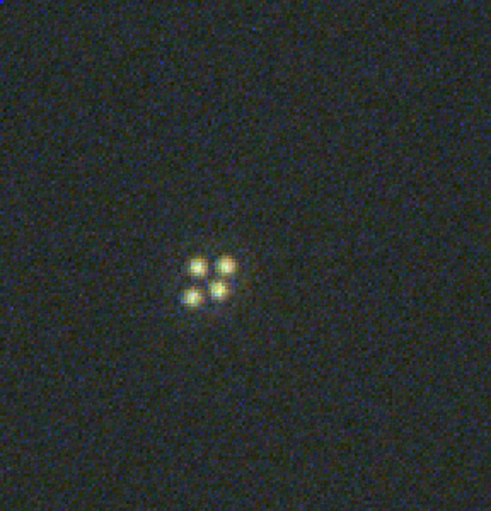

In [4]:
movf[1500]

Frame([[[ 39, 126, 204],
        [ 39,  85, 204],
        [ 44,  30,  50],
        ...,
        [ 57,  47,  48],
        [ 24,  40,  35],
        [ 24,  47,  35]],

       [[ 39,  85, 204],
        [ 39,  45, 204],
        [ 44,  34,  50],
        ...,
        [ 57,  53,  48],
        [ 24,  47,  35],
        [ 24,  54,  35]],

       [[ 25,  40,  18],
        [ 25,  38,  18],
        [ 54,  47,  24],
        ...,
        [ 59,  45,  23],
        [ 33,  33,  66],
        [ 33,  34,  66]],

       ...,

       [[ 39,  47,  68],
        [ 39,  41,  68],
        [ 33,  47,  31],
        ...,
        [ 35,  51,  26],
        [ 38,  42,  50],
        [ 38,  33,  50]],

       [[ 41,  33,  30],
        [ 41,  37,  30],
        [ 33,  53,  24],
        ...,
        [ 43,  54,  43],
        [ 36,  65,  55],
        [ 36,  57,  55]],

       [[ 41,  37,  30],
        [ 41,  42,  30],
        [ 33,  47,  24],
        ...,
        [ 43,  44,  43],
        [ 36,  57,  55],
        [ 36,  49,  55]]], dtype=uint8)
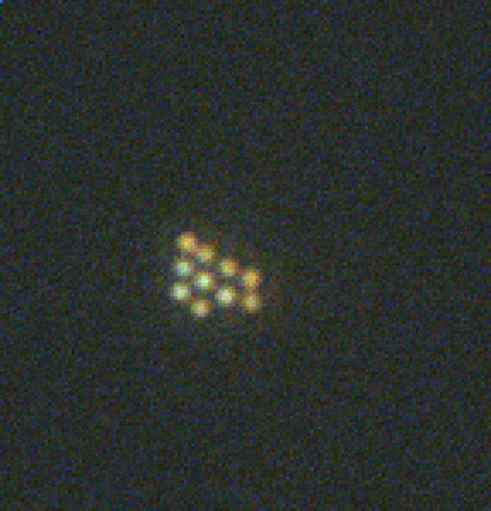

In [5]:
movg[1500]

Frame([[[ 29, 199, 186],
        [ 29, 119, 186],
        [ 43,  45,  34],
        ...,
        [ 32,  38,  44],
        [ 51,  47,  51],
        [ 51,  43,  51]],

       [[ 29, 119, 186],
        [ 29,  40, 186],
        [ 43,  42,  34],
        ...,
        [ 32,  38,  44],
        [ 51,  43,  51],
        [ 51,  39,  51]],

       [[ 33,  33,  63],
        [ 33,  40,  63],
        [ 46,  34,  22],
        ...,
        [ 55,  38,  32],
        [ 28,  54,  12],
        [ 28,  51,  12]],

       ...,

       [[ 15,  40,  46],
        [ 15,  23,  46],
        [ 26,  53,  43],
        ...,
        [ 39,  52,  25],
        [ 44,  41,  10],
        [ 44,  46,  10]],

       [[ 35,  33,  53],
        [ 35,  46,  53],
        [ 40,  48,  45],
        ...,
        [ 33,  46,  73],
        [ 44,  41,  46],
        [ 44,  38,  46]],

       [[ 35,  46,  53],
        [ 35,  59,  53],
        [ 40,  50,  45],
        ...,
        [ 33,  40,  73],
        [ 44,  38,  46],
        [ 44,  35,  46]]], dtype=uint8)
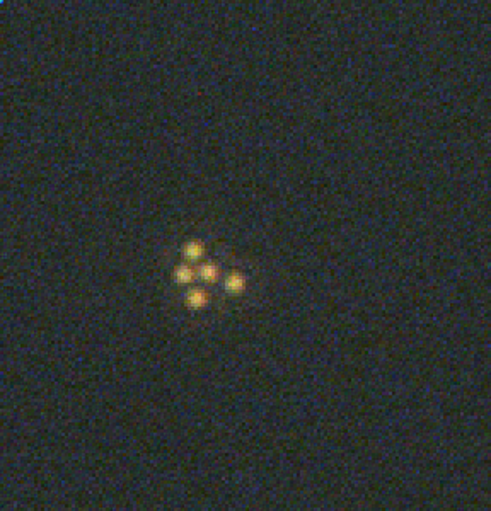

In [6]:
movh[1500]

Single particle tracking only works with 1-channel (black and white) tif videos, so grayscale versions of each file are needed to detect particle positions.

In [7]:
movf_gray = pims.as_gray(pims.open('Mov f.tif'))
movg_gray = pims.as_gray(pims.open('Mov g.tif'))
movh_gray = pims.as_gray(pims.open('Mov h.tif'))

Frame([[22.4504, 32.466 , 33.848 , ..., 44.1326, 59.987 , 52.833 ],
       [32.466 , 43.197 , 41.002 , ..., 52.7174, 52.833 , 45.679 ],
       [35.4514, 41.1746, 45.9201, ..., 54.0062, 47.0136, 40.575 ],
       ...,
       [45.7933, 42.9317, 38.829 , ..., 39.8578, 33.9375, 32.5067],
       [45.3679, 43.9371, 50.1087, ..., 39.5293, 34.1592, 37.0208],
       [43.9371, 42.5063, 47.9625, ..., 38.0985, 37.0208, 39.8824]])
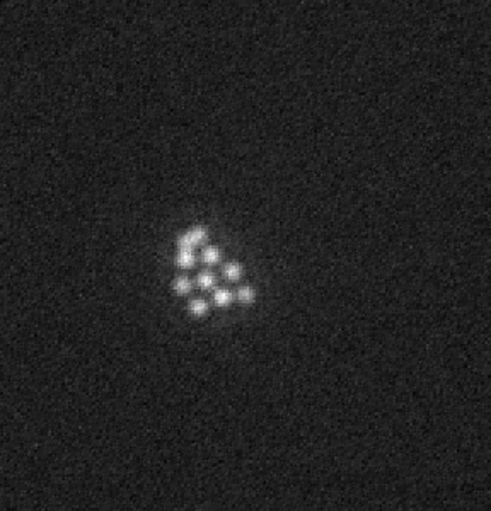

In [8]:
movg_gray[1677]

<font size='6'>Single-Particle Tracking with trackpy</font>

<font size='4'>Single-particle tracking an extremely important technique in several different scientific fields ranging from cell biology to condensed matter physics. In this particular case the particle tracking task is relatively simple. Preserving the identity of the particles between different frames is not important and the videos are relatively clean. Below I track and annotate a test-frame so that I can tune two parameters to find suitable values. Diameter is the diameter in pixels of the particles that are being tracked. In trackpy diameter should be an odd integer. minmass is associated with the brightness of each particle.</font>

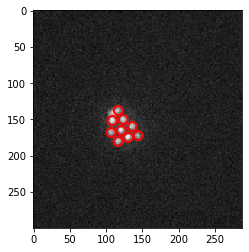

<AxesSubplot:>

In [9]:
test_frame = 1677
tracked_positions_test = tp.locate(movg_gray[test_frame], diameter=9, minmass=600)
tp.annotate(tracked_positions_test, movg_gray[test_frame], plot_style={'markersize': 9})

In [10]:
tracked_positions_test.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
136,137.137962,115.930574,800.491781,2.440206,0.157890,30.993674,7616.2440,0.032832,1677
149,149.849527,123.741878,1206.259532,2.506253,0.011212,40.078026,8680.8662,0.027096,1677
150,151.252484,108.716764,1129.487846,2.510065,0.014171,40.078026,9142.1401,0.025189,1677
159,158.979142,135.492284,1050.400541,2.483590,0.052862,39.365528,7881.8378,0.031185,1677
164,164.225396,120.253664,1190.940820,2.429841,0.077912,45.065514,8624.8054,0.027347,1677


Now that I have found suitable values for the parameters, I will create a function that tracks the entire videos and apply them to each of the videos. The output of the function will be a pandas dataframe.

In [11]:
def track_particle_positions(vid):
    frame_index = np.arange(len(vid))
    #frame_index = np.arange(500,505)
    tracked_pos = pd.DataFrame(columns=tp.locate(vid[0], diameter=9, minmass=600).columns)
    for frame in frame_index:
        tracked_pos_temp = tp.locate(vid[frame], diameter=9, minmass=600)
        tracked_pos = pd.concat([tracked_pos,tracked_pos_temp],axis=0,ignore_index=True)
    return tracked_pos


In [12]:
tracked_positions_f = track_particle_positions(movf_gray)
tracked_positions_g = track_particle_positions(movg_gray)
tracked_positions_h = track_particle_positions(movh_gray)

C:\ProgramData\Anaconda3\lib\site-packages\trackpy\feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


In [13]:
tracked_positions_f.head(10)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,152.216293,112.869082,1486.412564,2.462586,0.044761,56.972073,8821.6492,0.030413,0
1,166.169009,118.418409,1303.431670,2.483369,0.019159,46.694758,8397.7026,0.032559,0
2,152.681493,113.926608,1364.116602,2.445823,0.114876,55.258099,8494.5937,0.031402,1
3,166.399065,115.647533,1343.963648,2.490194,0.068328,50.490734,8558.6600,0.031079,1
4,155.498089,112.956055,1434.271759,2.545183,0.029729,46.797227,8614.5405,0.037079,2
5,170.652206,115.660093,1443.125289,2.499722,0.113667,53.753571,8721.3684,0.036455,2
6,151.161405,111.145810,1564.630711,2.546910,0.037993,50.587147,8953.3331,0.033658,3
7,167.130855,113.109758,1579.707665,2.575008,0.034317,47.016290,9218.7342,0.032371,3
8,148.711064,113.012716,1508.212449,2.556519,0.030337,48.243817,8968.0894,0.041494,4
9,163.998643,114.790675,1602.920599,2.552568,0.046321,50.221023,9233.6297,0.039866,4


In [14]:
movf_array = np.array(movf)
movg_array = np.array(movg)
movh_array = np.array(movh)

<font size='6'>Particle Intensity Calculation Using Binary Masks</font>

<font size='4'>Now that I have the particle positions in each of the videos, I need to calculate the intensity of all three channels of the tif files for each particle. This can be done by creating binary masks that set all pixel intensities that are more than a certain distance away from a particle position to zero. Each of the three channels of the tif files can then be summed over to measure the red, green, and blue intensity associated with each particle. I define two functions below for this purpose. The first creates a binary mask that sets everything not near any tracked particle positions in that frame to zero. This is useful for visualization purposes. The second creates a binary mask around each particle position in each frame individually, and sums over the red, green, and blue channels of the video and gives a 3-dimensional vector associated with the color of each tracked pareticle as output.</font>

In [15]:
def mask_frame_by_pos(img, positions, mask_radius=7):
    mask_temp = np.zeros((len(positions.index),img.shape[0],img.shape[1]))
    pixel_index = np.array(np.meshgrid(np.arange(img.shape[1]),np.arange(img.shape[0])))
    for n1 in range(len(positions.index)):
        x_dist_temp = positions['x'].iloc[n1] - pixel_index[0,:,:]
        y_dist_temp = positions['y'].iloc[n1] - pixel_index[1,:,:]
        sq_dist_temp = x_dist_temp**2 + y_dist_temp**2
        mask_temp[n1,:,:] = sq_dist_temp < mask_radius**2
    mask = (np.sum(mask_temp,axis=0) != 0)
    return np.repeat(mask[:, :, np.newaxis], 3, axis=2)*img


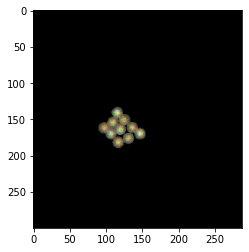

In [16]:
test_frame = 1545

index_temp = (tracked_positions_g['frame'] == test_frame)
test_mask = mask_frame_by_pos(movg_array[test_frame,:,:,:],tracked_positions_g[['x','y']][index_temp], mask_radius=8)
plt.imshow(test_mask)

In [17]:
def rgb_by_particle(img, pos, mask_radius=7):
    pixel_index = np.array(np.meshgrid(np.arange(img.shape[1]),np.arange(img.shape[0])))
    x_dist_temp = pos['x'] - pixel_index[0,:,:]
    y_dist_temp = pos['y'] - pixel_index[1,:,:]
    sq_dist_temp = x_dist_temp**2 + y_dist_temp**2
    mask_temp = sq_dist_temp < mask_radius**2
    r_img, g_img, b_img = np.sum(img[mask_temp,0]), np.sum(img[mask_temp,1]), np.sum(img[mask_temp,2])
    return r_img, g_img, b_img

In [18]:
index_temp = (tracked_positions_g['frame'] == 1279)
rgb_by_particle(movg_array[1279,:,:,:],tracked_positions_g[['x','y']][index_temp].iloc[3])

(21723, 21521, 15360)

In [19]:
particle_color_movf = pd.DataFrame(columns=['r','g','b','total'], index=tracked_positions_f.index)
particle_color_movg = pd.DataFrame(columns=['r','g','b','total'], index=tracked_positions_g.index)
particle_color_movh = pd.DataFrame(columns=['r','g','b','total'], index=tracked_positions_h.index)


In [20]:
for frame in tracked_positions_f['frame'].unique():
    index_temp = (tracked_positions_f['frame'] == frame)
    for ind in index_temp[index_temp].index.tolist():
        frame = int(frame)
        rgb_temp = rgb_by_particle(movf_array[frame,:,:,:],tracked_positions_f[['x','y']][index_temp].loc[ind])
        particle_color_movf['total'].loc[ind] = np.sum(rgb_temp)
        particle_color_movf['r'].loc[ind] = rgb_temp[0]/particle_color_movf['total'].loc[ind]
        particle_color_movf['g'].loc[ind] = rgb_temp[1]/particle_color_movf['total'].loc[ind]
        particle_color_movf['b'].loc[ind] = rgb_temp[2]/particle_color_movf['total'].loc[ind]

In [21]:
for frame in tracked_positions_g['frame'].unique():
    index_temp = (tracked_positions_g['frame'] == frame)
    for ind in index_temp[index_temp].index.tolist():
        frame = int(frame)
        rgb_temp = rgb_by_particle(movg_array[frame,:,:,:],tracked_positions_g[['x','y']][index_temp].loc[ind])
        particle_color_movg['total'].loc[ind] = np.sum(rgb_temp)
        particle_color_movg['r'].loc[ind] = rgb_temp[0]/particle_color_movg['total'].loc[ind]
        particle_color_movg['g'].loc[ind] = rgb_temp[1]/particle_color_movg['total'].loc[ind]
        particle_color_movg['b'].loc[ind] = rgb_temp[2]/particle_color_movg['total'].loc[ind]

In [22]:
for frame in tracked_positions_h['frame'].unique():
    index_temp = (tracked_positions_h['frame'] == frame)
    for ind in index_temp[index_temp].index.tolist():
        frame = int(frame)
        rgb_temp = rgb_by_particle(movh_array[frame,:,:,:],tracked_positions_h[['x','y']][index_temp].loc[ind])
        particle_color_movh['total'].loc[ind] = np.sum(rgb_temp)
        particle_color_movh['r'].loc[ind] = rgb_temp[0]/particle_color_movh['total'].loc[ind]
        particle_color_movh['g'].loc[ind] = rgb_temp[1]/particle_color_movh['total'].loc[ind]
        particle_color_movh['b'].loc[ind] = rgb_temp[2]/particle_color_movh['total'].loc[ind]

In [23]:
particle_color_movf.head()

,r,g,b,total
0,0.360233,0.372969,0.266798,55514
1,0.355051,0.35751,0.287438,56927
2,0.351991,0.371396,0.276613,55348
3,0.363273,0.363521,0.273206,56580
4,0.35615,0.367112,0.276738,56100


Now that (r,g,b) vectors have been calculated for each tracked particle position, the next step is to analyze the results to inform how the classification will be done. I plot histograms for each of the three channels below in 'Mov f.tif' (all silver particles) and 'Mov h.tif'(all gold partticles).

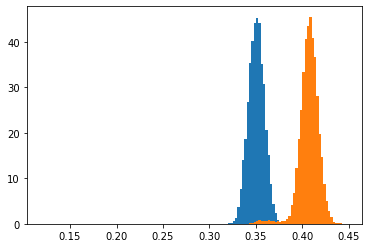

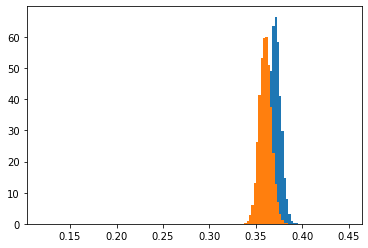

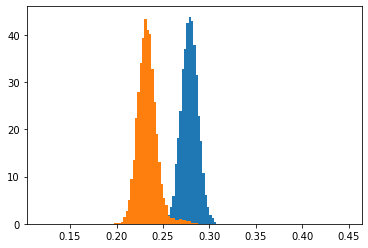

In [24]:
plt.hist(particle_color_movf['r'], bins=np.arange(0.12,0.45,0.0025), density=True)
plt.hist(particle_color_movh['r'], bins=np.arange(0.12,0.45,0.0025), density=True)
plt.show()

plt.hist(particle_color_movf['g'], bins=np.arange(0.12,0.45,0.0025), density=True)
plt.hist(particle_color_movh['g'], bins=np.arange(0.12,0.45,0.0025), density=True)
plt.show()

plt.hist(particle_color_movf['b'], bins=np.arange(0.12,0.45,0.0025), density=True)
plt.hist(particle_color_movh['b'], bins=np.arange(0.12,0.45,0.0025), density=True)
plt.show()

Luckily, there is really good seperation between the two particle types in the red and blue channels. This will make the classification nearly trivial. The long tails on the histograms corresponding to 'Mov h.tif' suggest that there may be a silver particle present for a few frames. This means that the training sets may not be perfectly classified. However, it is not immediately clear whether or not these anomolous frames will present a significant problem in building a classifier.

<font size='6'>Classification Using xgboost</font>

<font size='4'>
Now that the data has been transformed into convenient features, it's time to choose and fit a classifier. I'm going to use xgboost to perform the classification, but there are several equally valid choices for this particular task. The exact values of the hyperparameters are not important in this case because there is little ambiguity in where to split each feature, and there are only three features. Before building the classifier I will perform 5-fold cross validation and measure out-of-fold accuracy as well as AUC-ROC scores to evaluate the performance.
</font>

In [25]:
train_data = particle_color_movf
train_data['type'] = 0
train_data = pd.concat([train_data,particle_color_movh], ignore_index = True)
train_data = train_data.fillna(value=1)
train_data.head()

target_var = train_data.pop('type').astype('int')

In [26]:
kfold = KFold(n_splits=5, shuffle=True)

scores = []
auc = []
for train_index, test_index in kfold.split(train_data):   
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = target_var.iloc[train_index], target_var.iloc[test_index]

    clf = xgb.XGBClassifier(eval_metric = 'auc', alpha=7, reg_lambda=0, colsample_bytree=1, colsample_bylevel=1, gamma=1, learning_rate = 0.05, max_depth = 6, n_estimators = 450, subsample = .75, min_child_weight = 10 , use_label_encoder=False, tree_method = 'hist')
    clf.fit(X_train,y_train)
    
    pred = clf.predict(X_test)
    
    scores.append(1 - np.sum(np.abs(y_test - pred))/len(y_test))
    auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


print('out-of-fold accuracy: ', np.mean(scores))
print('AUC-ROC: ', np.mean(auc))

out-of-fold accuracy:  0.9877367335458466
AUC-ROC:  0.9984799914309255


This accuracy is acceptable considering the purpose of the data, and no further tuning is required. Now it's time to fit the classifier and classify the mixed particles.

In [27]:
mixed_data = pd.DataFrame(particle_color_movg)

In [28]:
clf = xgb.XGBClassifier(eval_metric = 'auc', alpha=7, reg_lambda=0, colsample_bytree=1, colsample_bylevel=1, gamma=1, learning_rate = 0.05, max_depth = 6, n_estimators = 450, subsample = .75, min_child_weight = 10 , use_label_encoder=False, tree_method = 'hist')
clf.fit(train_data,target_var)

prediction = clf.predict(mixed_data)


The function below can be used to evaluate the performance of the classifier. It generates three masked images of a specified frame. The first shows all particles. The second shows only particles classified as silver. The third shows only particles classified as gold.

In [88]:
def show_classification(frame):
    index_temp = (tracked_positions_g['frame'] == frame)

    index_silver = pd.Series(prediction == 0)
    index_gold = pd.Series(prediction == 1)

    masked_frame = mask_frame_by_pos(movg_array[frame,:,:,:],tracked_positions_g[['x','y']][index_temp], mask_radius=8)
    masked_frame_silver = mask_frame_by_pos(movg_array[frame,:,:,:],tracked_positions_g[['x','y']][index_temp][index_silver], mask_radius=8)
    masked_frame_gold = mask_frame_by_pos(movg_array[frame,:,:,:],tracked_positions_g[['x','y']][index_temp][index_gold], mask_radius=8)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=[21,7])

    ax1.imshow(masked_frame)
    ax2.imshow(masked_frame_silver)
    ax3.imshow(masked_frame_gold)




C:\Users\cwpet\AppData\Local\Temp/ipykernel_15920/2466665600.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  masked_frame_silver = mask_frame_by_pos(movg_array[frame,:,:,:],tracked_positions_g[['x','y']][index_temp][index_silver], mask_radius=8)
C:\Users\cwpet\AppData\Local\Temp/ipykernel_15920/2466665600.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  masked_frame_gold = mask_frame_by_pos(movg_array[frame,:,:,:],tracked_positions_g[['x','y']][index_temp][index_gold], mask_radius=8)


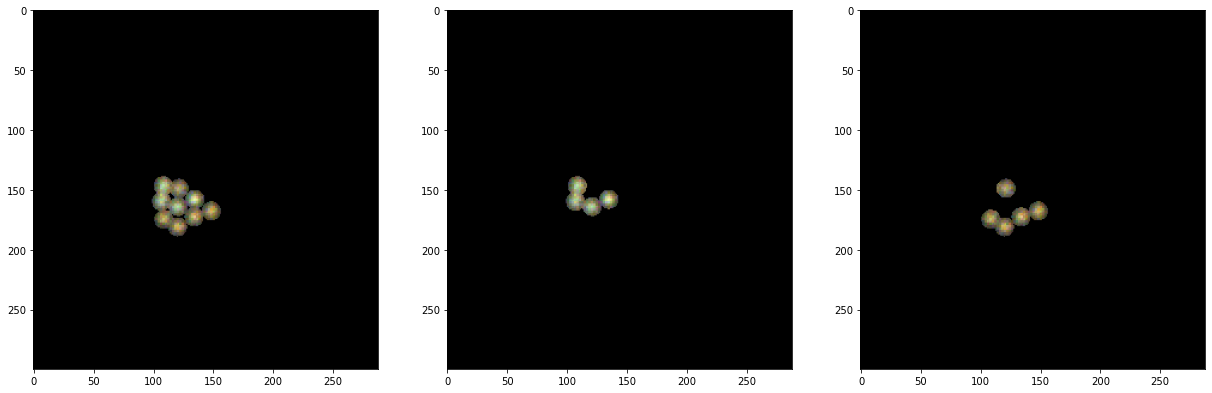

In [96]:
show_classification(1849)

Although the classifier performs very well, there are some errors. There are a few potential improvements that could be made to this method. These changes would not be trivial, and the increased accuracy should be weighed against the time and effort required to implement them.

- Many of the parameters used in this analysis, (e.g. mask size, particle tracking parameters) were not carefully evaluated. The accuracy achieved on the cross-validation could be tested for different values of these parameters to find optimal values.
- It is possible that post-processing of the images before the analysis was conducted may have improved the results.
- TrackPy is only one of several particle tracking methods available. While it is built on the most popular single-particle tracking algorithm ([Crocker-Grier](http://crocker.seas.upenn.edu/CrockerGrier1996b.pdf)), particle tracking is an active area of research and there are several alternative methods.
- In this analysis I treated every frame independently and I did not enforce that the proportion of silver-to-gold particles remain stable. Therefore, the accuracy of the method presented here could be improved , for example, by creating a more complicated classifier that includes temporal information or applies a penalty when the proportion of silver and gold particles change.
- Instead of using a binary mask, a function with softer edges could be applied. For example, 2-dimensional gaussians centered at each particle.